# HDA - Project 3

In [1]:
import utils
import deeplearning
import numpy as np
import time

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

from keras import regularizers
from keras.activations import relu
from keras.layers import Conv2D, BatchNormalization, Dropout, LeakyReLU, Flatten, Activation, Dense, MaxPooling2D, LSTM, Reshape
from keras.models import load_model, Model, Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


The following cell contains the hyper-parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- folder: directory name where '.mat' files are stored;
- label_col: column of features to be selected to perform activity detection, between [0,6]:

|  Label |  Feature |
|:-:     |:-:|
|  0     | Locomotion (TASK A)  |
|  1     | High Level Activity |
|  2     | Low Level Left Arm  |
|  3     | Low Level Left Arm Object  |
|  4     | Low Level Right Arm  |
|  5     | Low Level Right Arm Object  |
|  6     | Medium Level Both Arms (TASK B2) |

- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window.

The size of the temporal window seems to be fundamental in order to get a more specific and powerful model; of course the choice of the step lenght between consequent windows has to be consistent and to make sense. Thinking about a real-time situation, as long as we collect data we can use a sliding window of real-time samples; in this way, it is reasonable to use also a small value for the stride. Another important reason behind the choice of the value of the 

In [2]:
subject = 2
folder = "./data/full/"
#folder = "/floyd/input/hdadataset/full/" # To be used with FloydHub
label = 0     # default for task A
window_size = 64
stride = 3
C = [2**(-6)]

Let's load the models: 

In [3]:
start = time.time()
detection_model = load_model('./data/detection_model_A.h5')
end = time.time()
print("Time to load the detection model: %.3f s" % (end - start))

start = time.time()
classification_model = load_model('./data/classification_model_A.h5')
end = time.time()
print("Time to load the classification model: %.3f s" % (end - start))

Time to load the detection model: 4.881 s
Time to load the classification model: 5.016 s


# USER 1
### Detection

In [4]:
[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(1,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    make_binary = True)

Training samples:  157125 
Test samples:       57536 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (52354, 64, 110) 
Dataset of Labels have shape:    (52354, 2) 
Fraction of labels:   [0.10986744 0.89013256]
TEST SET:
Dataset of Images have shape:  (19157, 64, 110) 
Dataset of Labels have shape:    (19157, 2) 
Fraction of labels:   [0.17737642 0.82262358]


In [5]:
n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 2

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = detection_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

Time to evaluate predictions: 20.685


Accuracy:  0.9184110246907136
F1-measure:  0.9106235291416435


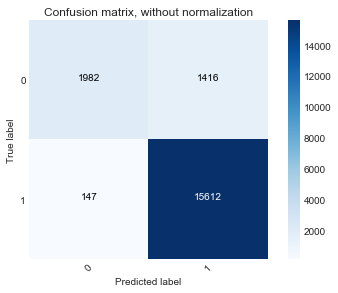

In [6]:
print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

In [7]:
print(classification_report(np.argmax(y_test, axis=1), prediction))

             precision    recall  f1-score   support

          0       0.93      0.58      0.72      3398
          1       0.92      0.99      0.95     15759

avg / total       0.92      0.92      0.91     19157



### Classification

In [8]:
[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(1,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    null_class = False)

Training samples:  157125 
Test samples:       57536 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (46601, 64, 110) 
Dataset of Labels have shape:    (46601, 4) 
Fraction of labels:   [0.47 0.31 0.19 0.03]
TEST SET:
Dataset of Images have shape:  (15758, 64, 110) 
Dataset of Labels have shape:    (15758, 4) 
Fraction of labels:   [0.42 0.25 0.29 0.05]


In [9]:
n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 4

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = classification_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

Time to evaluate predictions: 30.695


Accuracy:  0.8960527985784998


C:\Users\Riccardo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-measure:  0.8738878716272699


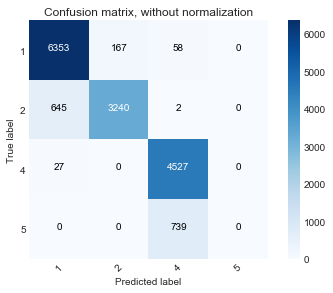

In [10]:
# Performances

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

In [11]:
print(classification_report(np.argmax(y_test, axis=1), prediction))

C:\Users\Riccardo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.90      0.97      0.93      6578
          1       0.95      0.83      0.89      3887
          2       0.85      0.99      0.92      4554
          3       0.00      0.00      0.00       739

avg / total       0.86      0.90      0.87     15758



In [12]:
# SVM Feature Extraction

input_train = x_train.reshape(x_train.shape[0], window_size, n_features, 1)
[trainingFeatures, testingFeatures] = deeplearning.extractFeatures(classification_model,
                                                                   input_train,
                                                                   input_test,
                                                                   classification_model.layers[-1].output_shape[1],
                                                                   batchSize = 300)
# SVM Prediction

output_train = np.argmax(y_train, axis=1)
prediction_svm = deeplearning.SVMLayer(C,
                                        output_train,
                                        trainingFeatures,
                                        testingFeatures) 

Computing DNN features on the training set...


TRAINING: 100%|###################################################| 156/156 [00:50<00:00,  3.10it/s]


Computing DNN features on the testing set...


TESTING: 100%|######################################################| 53/53 [00:14<00:00,  3.54it/s]


Training the model with C = 0.0156 ...


Accuracy with SVM:  0.900431526843508


C:\Users\Riccardo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-measure with SVM:  0.8788082752695194


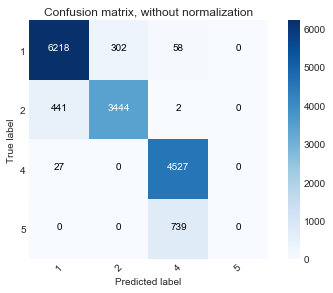

In [13]:
# Performances with SVM

print("Accuracy with SVM: ", accuracy_score(np.argmax(y_test, axis=1), prediction_svm))
print("F1-measure with SVM: ", utils.f1_score(np.argmax(y_test, axis=1), prediction_svm, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction_svm)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

In [15]:
print(classification_report(np.argmax(y_test, axis=1), prediction_svm))

C:\Users\Riccardo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.93      0.95      0.94      6578
          1       0.92      0.89      0.90      3887
          2       0.85      0.99      0.92      4554
          3       0.00      0.00      0.00       739

avg / total       0.86      0.90      0.88     15758



# USER 2

Training samples:  145808 
Test samples:       57720 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (48581, 64, 110) 
Dataset of Labels have shape:    (48581, 2) 
Fraction of labels:   [0.09 0.91]
TEST SET:
Dataset of Images have shape:  (19219, 64, 110) 
Dataset of Labels have shape:    (19219, 2) 
Fraction of labels:   [0.16 0.84]
Time to evaluate predictions: 19.467
Accuracy:  0.9155002861751392
F1-measure:  0.906244929415962


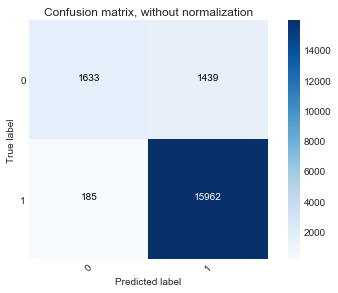

In [12]:
# Detection

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(2,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    make_binary = True)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 2

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = detection_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

Training samples:  145808 
Test samples:       57720 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (44182, 64, 110) 
Dataset of Labels have shape:    (44182, 4) 
Fraction of labels:   [0.46 0.3  0.22 0.02]
TEST SET:
Dataset of Images have shape:  (16145, 64, 110) 
Dataset of Labels have shape:    (16145, 4) 
Fraction of labels:   [0.37 0.28 0.31 0.04]
Time to evaluate predictions: 21.009
Accuracy:  0.49408485599256735


C:\Users\Riccardo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-measure:  0.38782601283951085


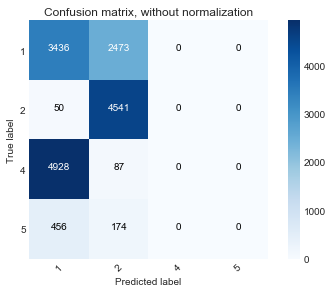

In [13]:
# Classification

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(2,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    null_class = False)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 4

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = classification_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

Computing DNN features on the training set...


TRAINING: 100%|###################################################| 148/148 [00:41<00:00,  3.56it/s]


Computing DNN features on the testing set...


TESTING: 100%|######################################################| 54/54 [00:15<00:00,  3.53it/s]


Training the model with C = 0.0156 ...
Accuracy with SVM:  0.6956333230102199


C:\Users\Riccardo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-measure with SVM:  0.6785404532796225


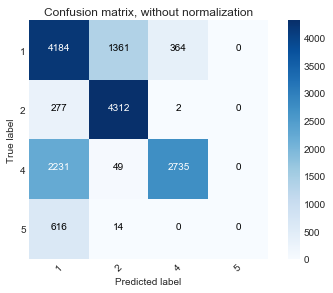

In [14]:
# SVM Feature Extraction

input_train = x_train.reshape(x_train.shape[0], window_size, n_features, 1)
[trainingFeatures, testingFeatures] = deeplearning.extractFeatures(classification_model,
                                                                   input_train,
                                                                   input_test,
                                                                   classification_model.layers[-1].output_shape[1],
                                                                   batchSize = 300)
# SVM Prediction

output_train = np.argmax(y_train, axis=1)
prediction_svm = deeplearning.SVMLayer(C,
                                        output_train,
                                        trainingFeatures,
                                        testingFeatures) 

# Performances with SVM

print("Accuracy with SVM: ", accuracy_score(np.argmax(y_test, axis=1), prediction_svm))
print("F1-measure with SVM: ", utils.f1_score(np.argmax(y_test, axis=1), prediction_svm, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction_svm)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

# USER 3

Training samples:  150098 
Test samples:       49005 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (50011, 64, 110) 
Dataset of Labels have shape:    (50011, 2) 
Fraction of labels:   [0.02 0.98]
TEST SET:
Dataset of Images have shape:  (16314, 64, 110) 
Dataset of Labels have shape:    (16314, 2) 
Fraction of labels:   [0.06 0.94]
Time to evaluate predictions: 16.563
Accuracy:  0.9021699154100772
F1-measure:  0.9053812823050013


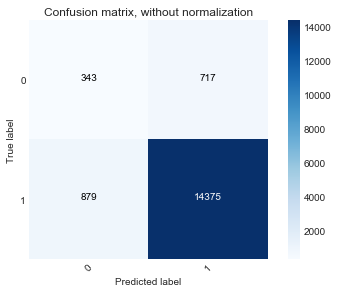

In [15]:
# Detection

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(3,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    make_binary = True)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 2

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = detection_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

Training samples:  150098 
Test samples:       49005 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (48988, 64, 110) 
Dataset of Labels have shape:    (48988, 4) 
Fraction of labels:   [0.58 0.25 0.13 0.04]
TEST SET:
Dataset of Images have shape:  (15254, 64, 110) 
Dataset of Labels have shape:    (15254, 4) 
Fraction of labels:   [0.43 0.29 0.2  0.08]
Time to evaluate predictions: 19.687
Accuracy:  0.6938507932345614
F1-measure:  0.6273915452369014


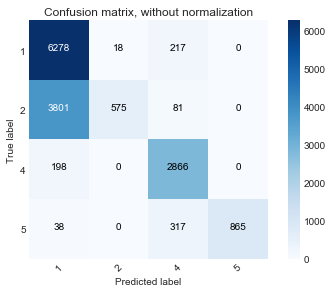

In [16]:
# Classification

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(3,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    null_class = False)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 4

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = classification_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

Computing DNN features on the training set...


TRAINING: 100%|###################################################| 164/164 [00:46<00:00,  3.56it/s]


Computing DNN features on the testing set...


TESTING: 100%|######################################################| 51/51 [00:14<00:00,  3.52it/s]


Training the model with C = 0.0156 ...
Accuracy with SVM:  0.7901534023862593
F1-measure with SVM:  0.7774776844591843


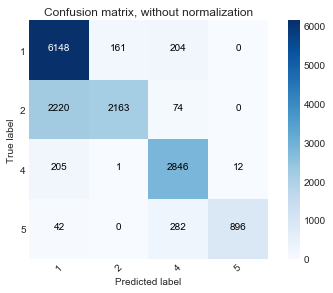

In [17]:
# SVM Feature Extraction

input_train = x_train.reshape(x_train.shape[0], window_size, n_features, 1)
[trainingFeatures, testingFeatures] = deeplearning.extractFeatures(classification_model,
                                                                   input_train,
                                                                   input_test,
                                                                   classification_model.layers[-1].output_shape[1],
                                                                   batchSize = 300)
# SVM Prediction

output_train = np.argmax(y_train, axis=1)
prediction_svm = deeplearning.SVMLayer(C,
                                        output_train,
                                        trainingFeatures,
                                        testingFeatures) 

# Performances with SVM

print("Accuracy with SVM: ", accuracy_score(np.argmax(y_test, axis=1), prediction_svm))
print("F1-measure with SVM: ", utils.f1_score(np.argmax(y_test, axis=1), prediction_svm, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction_svm)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

# USER 4

Training samples:  118493 
Test samples:       45675 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (39476, 64, 110) 
Dataset of Labels have shape:    (39476, 2) 
Fraction of labels:   [0.09 0.91]
TEST SET:
Dataset of Images have shape:  (15204, 64, 110) 
Dataset of Labels have shape:    (15204, 2) 
Fraction of labels:   [0.15 0.85]
Time to evaluate predictions: 15.463
Accuracy:  0.9652065245987898
F1-measure:  0.9643888154077298


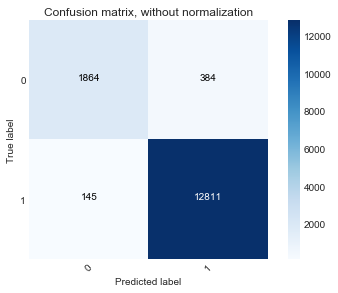

In [18]:
# Detection

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(4,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    make_binary = True)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 2

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = detection_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Confusion matrix, without normalization')

Training samples:  118493 
Test samples:       45675 
Features:             110
TRAINING SET:
Dataset of Images have shape:  (36042, 64, 110) 
Dataset of Labels have shape:    (36042, 4) 
Fraction of labels:   [0.55 0.25 0.17 0.03]
TEST SET:
Dataset of Images have shape:  (12956, 64, 110) 
Dataset of Labels have shape:    (12956, 4) 
Fraction of labels:   [0.44 0.36 0.15 0.04]
Time to evaluate predictions: 16.787
Accuracy:  0.8792837295461562
F1-measure:  0.8780330330008409


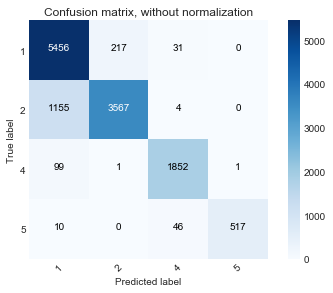

In [19]:
# Classification

[x_train, y_train, x_test, y_test, n_classes] = utils.preprocessing(4,
                                                                    folder,
                                                                    label,
                                                                    window_size,
                                                                    stride,
                                                                    null_class = False)

n_features = x_train.shape[2] #number of features taken into consideration for the solution of the problem
n_classes = 4

input_test = x_test.reshape(x_test.shape[0], window_size, n_features, 1)

start = time.time()
output_test = classification_model.predict(input_test)
end = time.time()
print("Time to evaluate predictions: %.3f" % (end - start))

prediction = np.argmax(output_test, axis=1)

print("Accuracy: ", accuracy_score(np.argmax(y_test, axis=1), prediction))
print("F1-measure: ", utils.f1_score(np.argmax(y_test, axis=1), prediction, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')

Computing DNN features on the training set...


TRAINING: 100%|###################################################| 121/121 [00:33<00:00,  3.57it/s]


Computing DNN features on the testing set...


TESTING: 100%|######################################################| 44/44 [00:12<00:00,  3.61it/s]


Training the model with C = 0.0156 ...
Accuracy with SVM:  0.8873880827415869
F1-measure with SVM:  0.8866432040242637


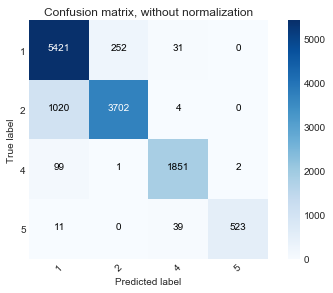

In [20]:
# SVM Feature Extraction

input_train = x_train.reshape(x_train.shape[0], window_size, n_features, 1)
[trainingFeatures, testingFeatures] = deeplearning.extractFeatures(classification_model,
                                                                   input_train,
                                                                   input_test,
                                                                   classification_model.layers[-1].output_shape[1],
                                                                   batchSize = 300)
# SVM Prediction

output_train = np.argmax(y_train, axis=1)
prediction_svm = deeplearning.SVMLayer(C,
                                        output_train,
                                        trainingFeatures,
                                        testingFeatures) 

# Performances with SVM

print("Accuracy with SVM: ", accuracy_score(np.argmax(y_test, axis=1), prediction_svm))
print("F1-measure with SVM: ", utils.f1_score(np.argmax(y_test, axis=1), prediction_svm, average='weighted'))

cnf_matrix = utils.confusion_matrix(np.argmax(y_test, axis=1), prediction_svm)
np.set_printoptions(precision=2)

sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=[1,2,4,5],
                      title='Confusion matrix, without normalization')